In [1]:
import pandas as pd
import networkx as nx
from itertools import combinations
from dotenv import load_dotenv
import os
import spacy
from community import community_louvain 

load_dotenv()

MIN_EDGE_WEIGHT = 15   
TOP_N_NODES = 200     

# ruídos de conversação
VERBOS_GENERICOS = {
    "ser", "ter", "estar", "ficar", "ir", "haver", "fazer", "dizer", "achar", 
    "ver", "coisa", "gente", "pra", "pro", "aí", "então", "né", "tá", "dar", 
    "poder", "querer", "saber", "falar", "usar", "melhor", "pior"
}
# -----------------------------------------------------------

COMMENT_COLUMN = "comment"
CLEAN_COMMENTS_PATH = os.getenv("CLEAN_COMMENTS_PATH")

df = pd.read_csv(CLEAN_COMMENTS_PATH)
print(f"Lendo {len(df)} comentários pré-processados...")
comments = df[COMMENT_COLUMN].fillna("").astype(str).tolist()

# lematização pelo SpaCy
nlp = spacy.load("pt_core_news_sm")
nlp.disable_pipes(["parser", "ner"]) 

def tokenize(text):
    doc = nlp(text)
    tokens_limpos = []
    for token in doc:
        lemma = token.lemma_.lower()
        # filtra apenas os verbos genéricos manuais e pontuação -> já usei NTLK antes
        if lemma not in VERBOS_GENERICOS and not token.is_punct and len(lemma) > 2:
            tokens_limpos.append(lemma)
    return tokens_limpos

G = nx.Graph()

print("Populando grafo...")
for i, comment in enumerate(comments):
    if i % 5000 == 0: print(f"Processando linha {i}...")
    
    palavras = tokenize(comment)
    palavras = list(set(palavras)) # remove duplicatas na mesma frase

    # cria conexões
    for w1, w2 in combinations(palavras, 2):
        if G.has_edge(w1, w2):
            G[w1][w2]["weight"] += 1
        else:
            G.add_edge(w1, w2, weight=1)

print(f"Grafo Bruto: {G.number_of_nodes()} nós, {G.number_of_edges()} arestas.")

# corta conexões fracas
print(f"Cortando conexões com peso menor que {MIN_EDGE_WEIGHT}...")
edges_to_remove = [(u, v) for u, v, w in G.edges(data="weight") if w < MIN_EDGE_WEIGHT]
G.remove_edges_from(edges_to_remove)

# remove nós isolados após o corte das arestas
G.remove_nodes_from(list(nx.isolates(G)))

# seleção dos 200 nós com mais grau
if G.number_of_nodes() > TOP_N_NODES:
    print(f"Filtrando para os top {TOP_N_NODES} termos mais centrais...")
    node_degrees = sorted(G.degree, key=lambda x: x[1], reverse=True)
    top_nodes = [n for n, d in node_degrees[:TOP_N_NODES]]
    G = G.subgraph(top_nodes).copy()
    G.remove_nodes_from(list(nx.isolates(G)))

# manter somente giant component para evitar ilhas isoladas
if len(G) > 0:
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

print("Calculando pesos normalizados...")
if G.number_of_edges() > 0:
    max_weight = max([G[u][v]["weight"] for u, v in G.edges()])
    for u, v in G.edges():
        G[u][v]["norm_weight"] = G[u][v]["weight"] / max_weight

    print(f"Tamanho final: {G.number_of_nodes()} nós (palavras) e {G.number_of_edges()} conexões.")
else:
    print("Grafo vazio")

# centralidade e modularidade
deg_cent = nx.degree_centrality(G)

partition = community_louvain.best_partition(
    G,
    weight="norm_weight",
    randomize=True,
    resolution=1.0
)

partition_para_gephi = {k: str(v) for k, v in partition.items()}

nx.set_node_attributes(G, partition_para_gephi, "comunidade_python")


mod = community_louvain.modularity(partition, G, weight="norm_weight")
print(f"Modularidade (Louvain): {mod:.4f}")


pasta_atual = os.getcwd()

# conversão de string para aplicação no Gephi
count = 0
for node in G.nodes():
    grupo = partition.get(node, "sem_grupo")
    G.nodes[node]['comunidade_python'] = str(grupo)
    count += 1

# salvando para formato de editar no Gephi
data_path = os.getenv("DATA_PATH")
caminho_gexf = os.path.join(data_path, "grafo_poster.gexf")
nx.write_gexf(G, caminho_gexf)



Lendo 52742 comentários pré-processados...
Populando grafo...
Processando linha 0...
Processando linha 5000...
Processando linha 10000...
Processando linha 15000...
Processando linha 20000...
Processando linha 25000...
Processando linha 30000...
Processando linha 35000...
Processando linha 40000...
Processando linha 45000...
Processando linha 50000...
Grafo Bruto: 26651 nós, 1832575 arestas.
Cortando conexões com peso menor que 15...
Filtrando para os top 200 termos mais centrais...
Calculando pesos normalizados...
Tamanho final: 200 nós (palavras) e 10564 conexões.
Modularidade (Louvain): 0.0859


Verificação dos termos:
lula: grupo 3, centralidade 1.0000
povo: grupo 0, centralidade 1.0000
bolsonaro: grupo 1, centralidade 1.0000
corrupção: grupo 2, centralidade 0.9899


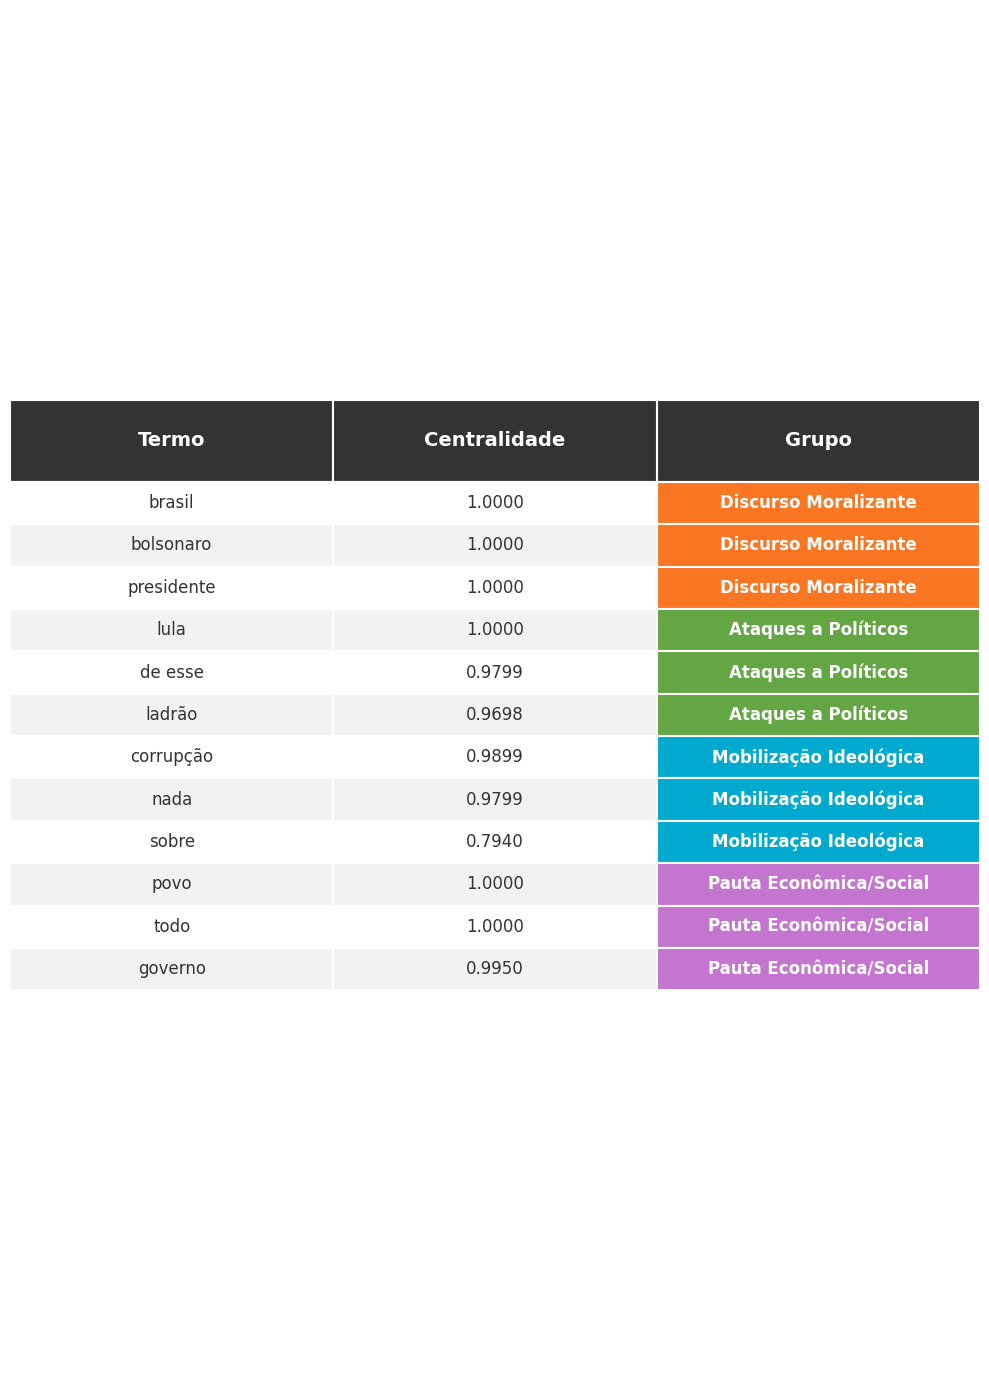

In [ ]:
# plotando gráficos
import matplotlib.pyplot as plt
import pandas as pd

# criando df
df = pd.DataFrame({
    "node": list(G.nodes()),
    "degree_centrality": [deg_cent[n] for n in G.nodes()],
    "community_louvain": [partition[n] for n in G.nodes()]
})

for termo in ["lula", "povo", "bolsonaro", "corrupção"]:
    if termo in df["node"].values:
        grupo = df[df["node"] == termo]["community_louvain"].values[0]
        cent = df[df["node"] == termo]["degree_centrality"].values[0]

NOMES_GRUPOS = {
    3: "Ataques a Políticos",      
    0: "Pauta Econômica/Social", 
    1: "Discurso Moralizante",     
    2: "Mobilização Ideológica"    
}

CORES_GEPHI = {
    3: "#63a643",  
    0: "#c475d0", 
    1: "#fa7622",  
    2: "#00a9ce"   
}

ORDEM_DESEJADA = [1, 3, 2, 0]

frames = []
for grupo in ORDEM_DESEJADA:
    df_grupo = df[df['community_louvain'] == grupo]
    df_grupo = df_grupo.sort_values(by="degree_centrality", ascending=False)
    frames.append(df_grupo.head(3))

df_top = pd.concat(frames, ignore_index=True)
df_top["degree_centrality_formatted"] = df_top["degree_centrality"].apply(lambda x: f"{x:.4f}")
df_top["Contexto"] = df_top["community_louvain"].map(NOMES_GRUPOS)

# fazendo tabela
fig, ax = plt.subplots(figsize=(10, 14)) 
ax.axis('off')
ax.axis('tight')

dados_tabela = df_top[["node", "degree_centrality_formatted", "Contexto"]].values
cabecalhos = ["Termo", "Centralidade", "Grupo"]

table = ax.table(cellText=dados_tabela,
                 colLabels=cabecalhos,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2.0) 

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('white')
    cell.set_linewidth(1.5)
    
    if row == 0:
        cell.set_text_props(weight='bold', color='white', size=14)
        cell.set_facecolor('#333333')
        cell.set_height(0.06)
    else:
        idx_real = row - 1
        com_id = df_top.iloc[idx_real]["community_louvain"]
        
        if col == 2:
            cor_fundo = CORES_GEPHI.get(com_id, "#cccccc")
            cell.set_facecolor(cor_fundo)
            cell.set_text_props(weight='bold', color='white')
        else:
            if row % 2 == 0:
                cell.set_facecolor('#f2f2f2')
            else:
                cell.set_facecolor('#ffffff')
            cell.set_text_props(color='#333333')

plt.tight_layout()
nome_saida = data_path + "/tabela_poster_final_ordenada.png"
plt.savefig(nome_saida, dpi=300, bbox_inches='tight')
plt.show()